In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import math

# Data Directory
dataDir = 'images'

# Define the window size
window_width = 800
window_height = 600

In [2]:
# Function to resize image
def resize_image(image, window_width, window_height):
    height, width = image.shape[:2]
    scaling_factor = min(window_width / width, window_height / height)
    return cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)

Image Dimensions: 3024 x 3024
Number of Channels: 3


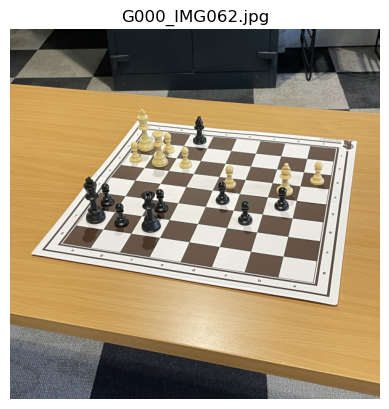

In [3]:
# Read and Display an Image
# Opening an image
img = cv2.imread(os.path.join(dataDir, 'G056_IMG097.jpg'))

# Get the dimensions of the image
height, width, channels = img.shape
print(f'Image Dimensions: {height} x {width}')
print(f'Number of Channels: {channels}')

# Calculate the scaling factor
scaling_factor = min(window_width / width, window_height / height)

# Resize the image
resized_img = resize_image(img, window_width, window_height)

# Display the resized image using matplotlib
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title('G000_IMG062.jpg')
plt.axis('off')
plt.show()

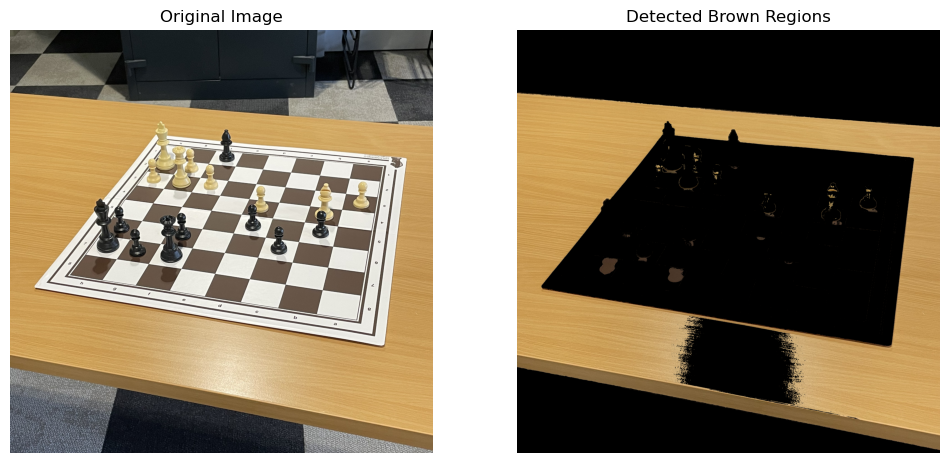

In [4]:
# Convert the image from BGR to HSV
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the HSV range for brown (adjust these values as needed)
brown_lower = np.array([10, 100, 0])
brown_upper = np.array([20, 255, 255])

# Create a mask for brown regions
mask = cv2.inRange(hsv_img, brown_lower, brown_upper)

# Apply the mask to extract brown regions
res = cv2.bitwise_and(img, img, mask=mask)

# Display the original and thresholded image side by side
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.title("Detected Brown Regions")
plt.axis("off")

plt.show()

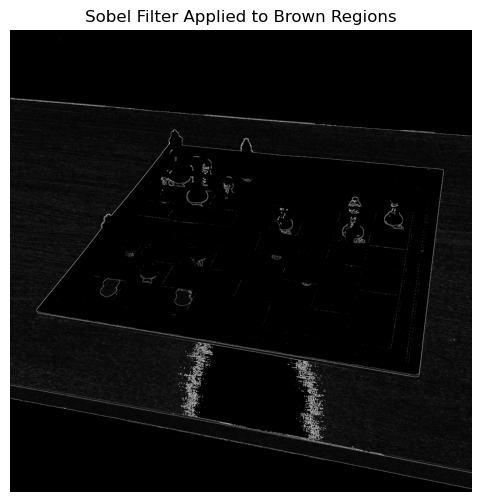

In [5]:
# Convert "res" to grayscale for Sobel processing
gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

# Apply Sobel filter in the x and y directions
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# Convert the gradients to absolute values
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

# Combine the gradients
sobel = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

# Display the result
plt.figure(figsize=(6,6))
plt.imshow(sobel, cmap='gray')
plt.title("Sobel Filter Applied to Brown Regions")
plt.axis("off")
plt.show()

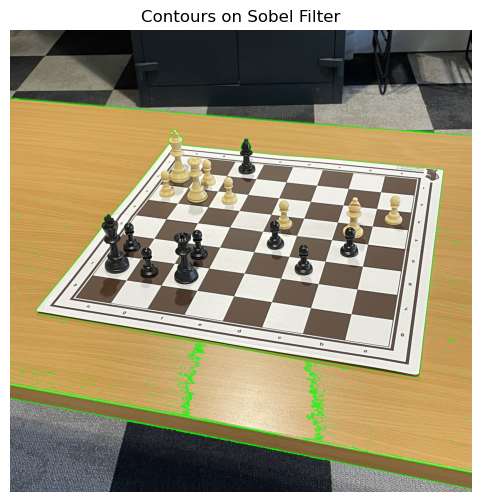

In [6]:
# Convert the Sobel output to a binary image using thresholding
_, thresh = cv2.threshold(sobel, 50, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on a copy of the original image
contour_img = img.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

# Display the contours overlaid on the original image
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title("Contours on Sobel Filter")
plt.axis("off")
plt.show()

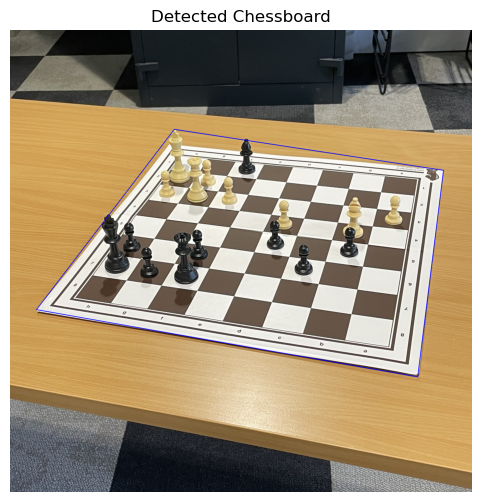

In [7]:
# ...existing code...

# Find contours in the binary image (already present)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize variables to keep track of the best candidate
chessboard_contour = None
center_point = (width // 2, height // 2)
min_distance = float('inf')

# Loop through detected contours to find a quadrilateral near the center.
for cnt in contours:
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    if len(approx) == 4:  # possible chessboard region (rectangle)
        M = cv2.moments(approx)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            distance = math.hypot(cx - center_point[0], cy - center_point[1])
            if distance < min_distance:
                min_distance = distance
                chessboard_contour = approx

# Draw and display the detected chessboard region if found
if chessboard_contour is not None:
    contour_img_with_chess = img.copy()
    cv2.drawContours(contour_img_with_chess, [chessboard_contour], -1, (255, 0, 0), 3)
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(contour_img_with_chess, cv2.COLOR_BGR2RGB))
    plt.title("Detected Chessboard")
    plt.axis("off")
    plt.show()
else:
    print("Chessboard contour not found")